In [4]:
# !pip install mlxtend

In [5]:
import pandas as pd
from mlxtend.frequent_patterns import apriori , association_rules
import matplotlib.pyplot as plt
import matplotlib.cm as cm

In [6]:
train=pd.read_csv("../../DataFiles/airline-train.csv")
# dropping the unnamed column (index) and id column
train=train.drop([train.columns[0],'id'], axis=1)

C:\Users\hp\AppData\Local\Temp\ipykernel_14884\3085495407.py:2: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('viridis')


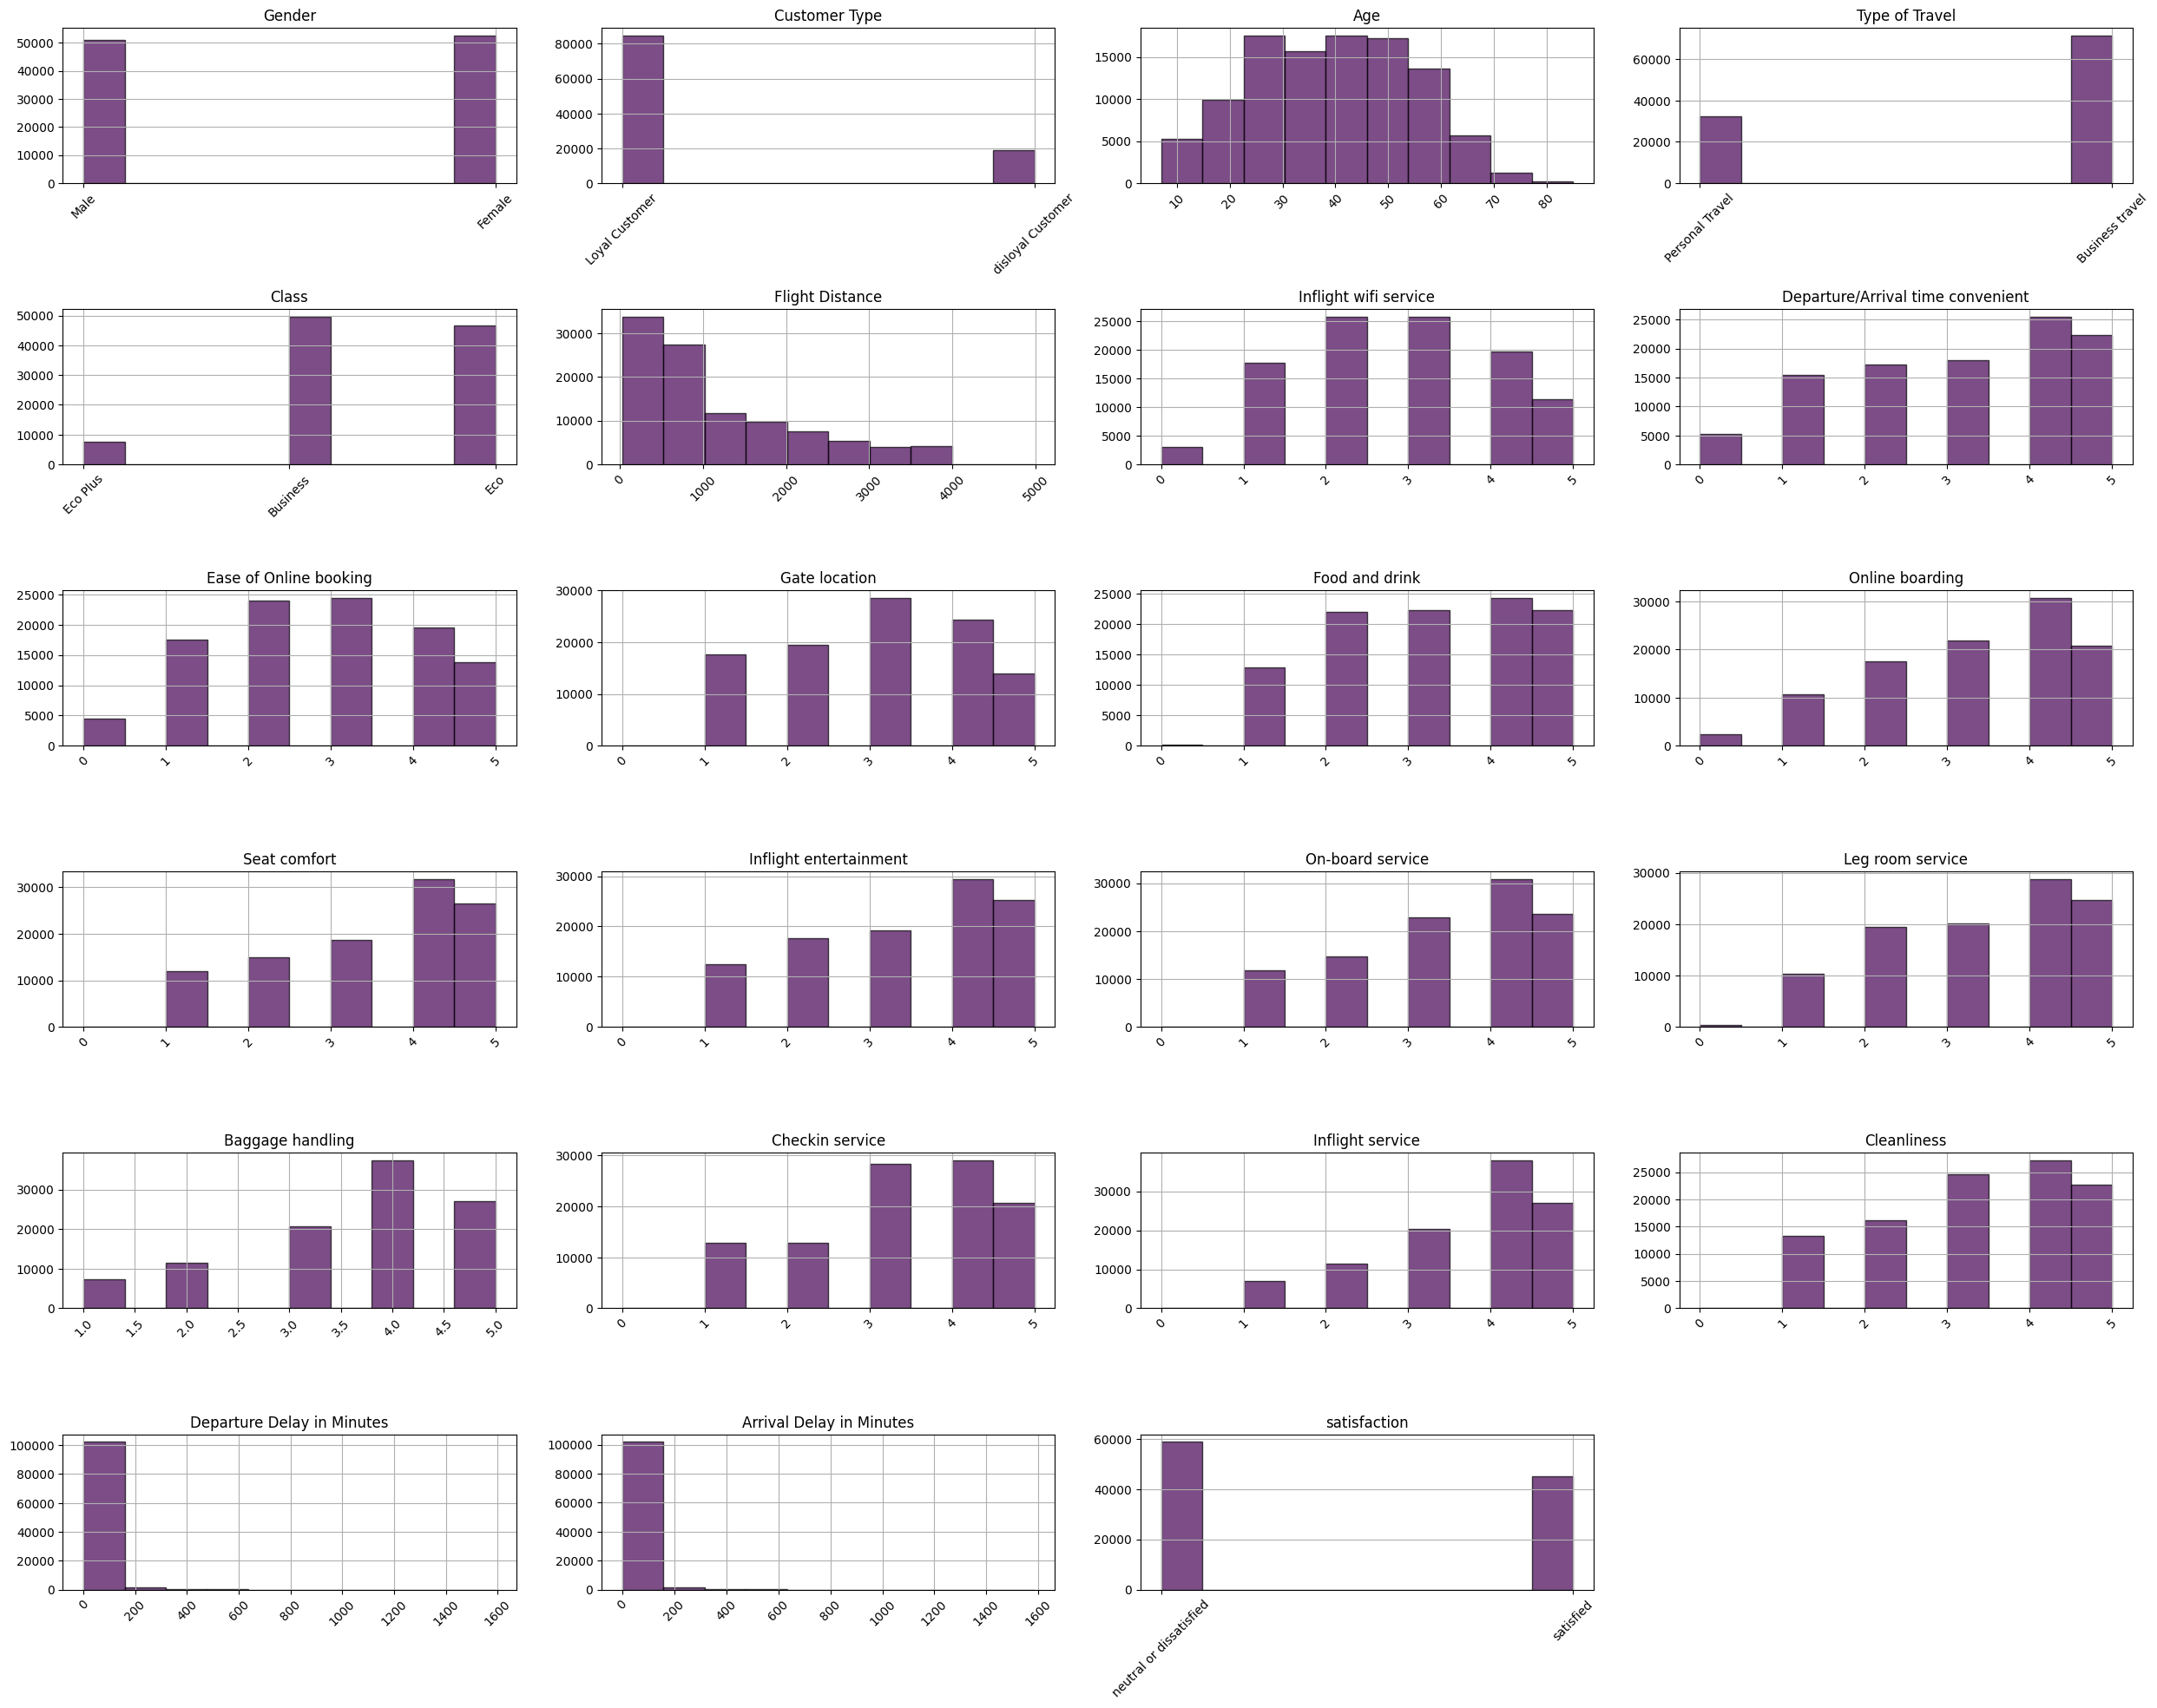

In [7]:
# set the colormap
cmap = cm.get_cmap('viridis')

# Plot the histogram for each variable
plt.figure(figsize=(25, 25))
for i, col_name in enumerate(train.columns):
    plt.subplot(8, 4, i+1)
    train[col_name].hist(color=cmap.colors[0], edgecolor='black', alpha=0.7)
    plt.title(col_name)
    plt.tick_params(axis='x', labelrotation=45)
plt.tight_layout()
plt.show()

### From Some data Exploration, we can conclude that: 
- only *Arrival Delay in Minutes* has Na values and is only 310 rows out of 103904 rows which we can easily drop and not consider. It is the only float column , the rest are int or categorical

- All columns has  numerical   values expect the following columns are categorical  with no Nulls. 


| Column    | Unique values |
| -------- | ------- |
| Gender  | Male, Female  |
| Customer Type    | Loyal Customer, disloyal Customer   |
| Class    | Eco Plus, Business, Eco   |
| Type of Travel | Personal Travel, Business travel    |
| satisfaction    | neutral or dissatisfied, satisfied   |

- The following columns are continous values that we can do some thresholding on them to convert them to categorical ones

| Column    | 
| -------- | 
| Age    | 
| Flight Distance | 
| Departure Delay in minutes|
| Arrival Delay in minutes| 

- However, from the histogram, it seems that Departure Delay & Arrival delay are very  +vely skewed ,and has no clear distinguish, so we can drop them as they donot convey clear info. 

- Since we will drop "Arrival Delay in Minutes" column, we no longer need to drop Na rows

- The rest of the columns are has int values that ranges from 0-5 as they are ratings.

- All columns need to be changed to one hot encoding as apriori needs it in this format 

In [8]:
train=train.drop(["Departure Delay in Minutes","Arrival Delay in Minutes"], axis=1)

In [9]:
# lets categories the age column into 3 groups 
train['Age']=pd.cut(train['Age'], bins=[0, 18, 65, 100], labels=['child', 'adult', 'elderly'])
# lets categories the flight column into 3 groups each of equal size
train['Flight Distance']=pd.qcut(train['Flight Distance'], q=3, labels=['low', 'medium', 'high'])

In [10]:
#change the data type of the columns to be able to one hot encode them
for i in train.columns:
    train[i] = train[i].astype('str')

# change the categorical data to one hot encoded different columns 
# as the apriori algorithm takes only numerical data 
train_encoded = pd.get_dummies(train)

### Now we are basically ready to train Apriori model after having a small daat cleaning and exploring

In [11]:
frequent_itemsets = apriori(train_encoded, min_support=0.35, use_colnames=True)

c:\Users\hp\AppData\Local\Programs\Python\Python311\Lib\site-packages\mlxtend\frequent_patterns\fpcommon.py:110: DeprecationWarning: DataFrames with non-bool types result in worse computationalperformance and their support might be discontinued in the future.Please use a DataFrame with bool type
  warnings.warn(


In [12]:
rules_df = association_rules(frequent_itemsets, metric="lift", min_threshold=1)

In [13]:
rules_df = rules_df.sort_values(['confidence', 'lift'], ascending =[False, False])

# get only the rules that has satisfaction as consequent(rhs of rule)

rules_df = rules_df[rules_df['consequents'].astype(str).str.contains('satisfaction')]

# write the rules to a txt file
rules_df.to_csv('rules.txt', sep='\t', index=False)



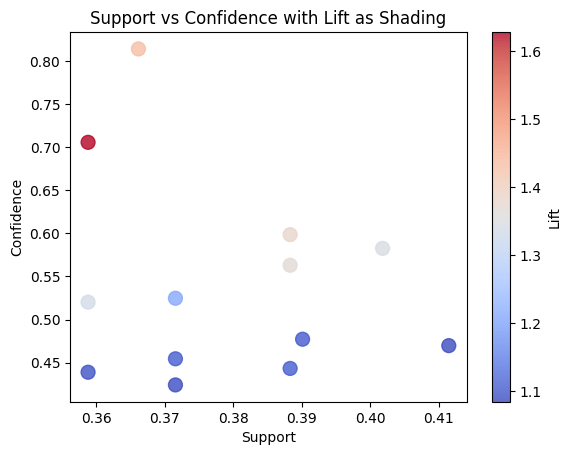

In [14]:
support=rules_df['support'].values
confidence=rules_df['confidence'].values
lift=rules_df['lift'].values

plt.scatter(support, confidence, c=lift, cmap='coolwarm', s=100, alpha=0.8)
# Add colorbar
cbar = plt.colorbar()
cbar.set_label('Lift')

# Add labels and title
plt.xlabel('Support')
plt.ylabel('Confidence')
plt.title('Support vs Confidence with Lift as Shading')

# Show the plot
plt.show()

In [15]:
# print the rules confidence and lift
print('support', 'confidence','lift')

for i in range(rules_df.shape[0]):
    print( rules_df.iloc[i]['support'], rules_df.iloc[i]['confidence'], rules_df.iloc[i]['lift'])


support confidence lift
0.3661456729288574 0.8138624451813029 1.4362262182462016
0.3587927317523868 0.7055528218327718 1.6282012304211508
0.3882814906067139 0.5985312662265411 1.3812280441088844
0.40177471512165075 0.5825971669806713 1.3444569914038793
0.3882814906067139 0.5630311911241366 1.3684489563172464
0.37154488758854326 0.5247811429503562 1.211035199935898
0.3587927317523868 0.5202707417486567 1.3336839402623155
0.39010047736372033 0.4772911931985445 1.1014428459322947
0.4114374807514629 0.46983701326533983 1.084240866770058
0.37154488758854326 0.4545882740835816 1.1048781293656247
0.3882814906067139 0.44339425644858177 1.1035892497971886
0.3587927317523868 0.438985904878537 1.0926170521846288
0.37154488758854326 0.4242820560727121 1.0876224990545746


### The most remarkable rules are :


| antecedent    | consequent |support | confidence  | lift   |
| -------- | ------- |-------- | ------- |------- |
| 'Customer Type_Loyal Customer', 'Type of Travel_Business travel' | satisfaction_satisfied |0.3587927317523868 |  0.7055528218327718 | 1.6282012304211508 |
| 'Class_Eco' | 'satisfaction_neutral or dissatisfied' | 0.3661456729288574|  0.8138624451813029  | 1.4362262182462016 |

- Those are the ones with the highest confidence and lift 

- in general it seems that "Type of Travel" seems the most potential attribute to distinguish between satisfaction and neutral or dissatisfied 